In [1]:
!pip install  InstructorEmbedding   duckduckgo-search langchain-core   huggingface_hub  sentence-transformers langchain-text-splitters  langchain-chroma    langchain_community  google-generativeai  langchain-google-genai    faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 89.6 MB/s eta 0:00:00


In [140]:
##### from InstructorEmbedding import INSTRUCTOR
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain_chroma import Chroma
import chromadb.utils.embedding_functions as embedding_functions
from dotenv import load_dotenv
from langchain.docstore.document import Document
import os
import google.generativeai as genai
from duckduckgo_search import DDGS
from bs4 import BeautifulSoup
import requests
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from typing import Any, List, Optional

from langchain_core.callbacks.manager import CallbackManagerForLLMRun
from langchain_core.language_models.llms import LLM
from langchain_core.outputs import GenerationChunk
from langchain_community.embeddings import HuggingFaceInstructEmbeddings
from langchain.load import dumps, loads

from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import faiss
import numpy as np
from datasets import load_dataset
from concurrent.futures import ThreadPoolExecutor


ds = load_dataset("HPAI-BSC/medqa-cot")

medqa_cot_embeds = np.load("medqa_cot.npy")

index = faiss.IndexFlatIP(768)
index.add(medqa_cot_embeds)

query_model = AutoModel.from_pretrained("ncbi/MedCPT-Query-Encoder")
query_tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Query-Encoder")

load_dotenv()


os.environ["GEMINI_API_KEY"] = ""


model_name = "hkunlp/instructor-xl"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
# https://arxiv.org/abs/2212.09741
instructor_embeddings = HuggingFaceInstructEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction="Represent the Medicine sentence for retrieving relevant documents: ",
)

instructor_embeddings.query_instruction = (
    "Represent the Medicine sentence for retrieving relevant documents: "
)

tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Cross-Encoder")
model = AutoModelForSequenceClassification.from_pretrained("ncbi/MedCPT-Cross-Encoder")


translate_model = genai.GenerativeModel("gemini-1.0-pro")  # buat translate


def translate_text(text, language):
    newText = text
    if language == "Indonesian":
        newText = text.replace("\n", " \n ")
    newText = (
        newText
        + f"; translate to {language}. please just translate the text and don't answer the questions!"
    )
    return translate_model.generate_content(newText).candidates[0].content.parts[0].text


summarizer_model = genai.GenerativeModel("gemini-1.5-flash-8b")


def user_summarizer(text):
    return summarizer_model.generate_content(text).candidates[0].content.parts[0].text


retriever_model = Chroma(
    collection_name="welllahh_rag_collection_chromadb",
    persist_directory="./chroma_langchain_db2",
    embedding_function=instructor_embeddings,
)

retriever = retriever_model.as_retriever(search_kwargs={"k": 10})


template = """Write multiple different very short search queries (each queries by a separated by "," & maximum different 5 very short search queries) that will help answer complex user questions, make sure in your answer you only give multiple different very short search queries (each queries by a separated by "," & maximum different 5 very short search queries) and don't include any other text! . Original question: {question}"""
search_query_prompt = ChatPromptTemplate.from_template(template)


class GeminiLLM(LLM):
    """custom model pakai gemini"""

    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> str:
        if stop is not None:
            raise ValueError("stop kwargs are not permitted.")
        llm = genai.GenerativeModel(
            model_name="tunedModels/geminiwelllahhzerotemplrfv3536-k5dv5w77flash"  # sebelumnya 0
        )  # buat jawab pertanyaan medis

        ans = (
            llm.generate_content(prompt, generation_config={"temperature": 0.12})
            .candidates[0]
            .content.parts[0]
            .text
        )
        return ans

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model. Used for logging purposes only."""
        return "gemini-welllahh-zerotemp-lrfv-3536"


llm = GeminiLLM()

generate_query = search_query_prompt | llm | StrOutputParser()

cant_access = {
    "npin.cdc.gov",
    "www.ncbi.nlm.nih.gov",
}  # gak bisa diakses & gak muncul tag <p> nya


def scrape_websearch(queryProc):
    websearch = []
    try:
        results = DDGS().text(queryProc, max_results=8)
    except Exception:
        return websearch
    for res in results:
        domain = res["href"].split("/")[2]
        if "webmd" in res["href"] or ".pdf" in res["href"] or domain in cant_access:
            continue
        if len(websearch) == 3:
            break
        if ".org" in res["href"] or ".gov" in res["href"] or "who" in res["href"]:

            link = res["href"]
            try:
                page = requests.get(link).text
            except requests.exceptions.RequestException as errh:
                print(f"error: {errh}")
                continue
            doc = BeautifulSoup(page, features="html.parser")
            text = ""
            hs = doc.find_all("h2")
            h3s = doc.find_all("h3")
            ps = doc.find_all("p")
            for h3 in h3s:
                hs.append(h3)
            for pp in ps:
                hs.append(pp)

            hs_parents = set()
            for h2 in hs:
                h2_parent = h2.parent
                if h2_parent in hs_parents:
                    continue
                hs_parents.add(h2_parent)
                h2_adjacent = h2_parent.children
                for adjacent in h2_adjacent:
                    if adjacent.name == "p" and adjacent.text != "\n":
                        text += adjacent.text + "\n"
                    if (
                        adjacent.name == "h2"
                        or adjacent.name == "h3"
                        or adjacent.name == "h4"
                    ):
                        text += adjacent.text + ": \n"
                    if adjacent.name == "ul" or adjacent.name == "ol":
                        text += ": "
                        for li in adjacent.find_all("li"):
                            text += li.text + ","
                        text += "\n"
            if "Why have I been blocked" in text or text == "" or text == ": \n":
                continue

            websearch.append(text)
    return websearch


def add_websearch_results(query):
    queries = [query]
    if "," in query:
        queries.extend(query.split(","))
    else:
        queries = [query]
    websearch_all = []

    with ThreadPoolExecutor(max_workers=2) as executor:
        results = executor.map(scrape_websearch, queries)
    for new_contexts in results:
        websearch_all.extend(new_contexts)

    return websearch_all


class DuckDuckGoRetriever(BaseRetriever):
    """ """

    """List of documents to retrieve from."""
    k: int
    """Number of top results to return"""

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        """Sync implementations for retriever."""
        matching_documents = []
        websearch = add_websearch_results(query)

        for document in websearch:
            if len(matching_documents) > self.k:
                return matching_documents

            matching_documents.append(document)
        return matching_documents


medqa_cot_data = ds["train"]


class MedQACoTRetriever(BaseRetriever):
    """List of documents to retrieve from."""

    k: int

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        """Sync implementations for retriever."""
        matching_documents = []
        # websearch = add_websearch_results(query)
        inds = []

        queries = [query]
        if "," in query:
            queries.extend(query.split(","))
        else:
            queries = [query]

        relevant_cot = []

        def retrieve_cot(search_query):
            with torch.no_grad():
                # tokenize the queries
                encoded = query_tokenizer(
                    [search_query],
                    truncation=True,
                    padding=True,
                    return_tensors="pt",
                    max_length=512,
                )
                embeds = query_model(**encoded).last_hidden_state[:, 0, :]
                scores, inds = index.search(embeds, k=self.k)

            curr_relevant_cot = []
            for score, ind in zip(scores[0], inds[0]):
                curr_cot = medqa_cot_data[int(ind)]
                curr_question = curr_cot["question"]
                curr_answer = curr_cot["response"]
                curr_relevant_cot.append(
                    f"\nQuestion: {curr_question}\nAnswer: Let's think step by step. {curr_answer}"
                )
            return curr_relevant_cot

        with ThreadPoolExecutor(max_workers=3) as executor:
            results = executor.map(retrieve_cot, queries)
        for new_contexts in results:
            relevant_cot.extend(new_contexts)

        return relevant_cot


websearch_retriever = DuckDuckGoRetriever(k=2)
medqa_cot_retriever = MedQACoTRetriever(k=2)


def rerank_docs_medcpt(question, docs):
  
    relevant = set()

    def process_query(query):
        pairs = [[query, article] for article in docs]
        with torch.no_grad():
            encoded = tokenizer(
                pairs,
                truncation=True,
                padding=True,
                return_tensors="pt",
                max_length=512,
            )

            logits = model(**encoded).logits.squeeze(dim=1)
            values, indices = torch.sort(logits, descending=True)
            curr_relevant = [docs[i] for i in indices[:8]]
        return curr_relevant

    
    results = process_query(question)

    for curr_relevant in results:
        relevant.add(curr_relevant)

    relevant = list(relevant)
    return relevant


retrieval_chain = generate_query | {
    "websearch": websearch_retriever,
    "query": StrOutputParser(),
}


def format_docs(docs, question):
    chroma_docs = [doc.metadata["content"] + doc.page_content for doc in docs["chroma"]]
    relevant_cot = docs["medqa_cot"]

    docs = list(set(chroma_docs + docs["websearch"]))
    # rerank passage2 dari document chromadb & hasil scraping webpage hasil duckduckgosearch
    relevant_docs = rerank_docs_medcpt(question, docs)

    context = " \n\n".join(doc for doc in relevant_docs)

    # tambahin few-shot chain-of-thought prompting
    relevant_cot = list(set(relevant_cot))[:2]
    for cot in relevant_cot:
        context += " \n" + cot
    return context, relevant_docs


template = """Answer the question based only on the following context:
{context}
\n

please do not mention the same answer more than once and Don't say 'the given text does not answer the user's question or is not relevant to the user's question' in your answer. just answer the question don't add any other irrelevant text
\n
Question: {question}
\n
Answer: Let's think step by step.
"""

prompt = ChatPromptTemplate.from_template(template)

answer_chain = prompt | llm | {"llm_output": StrOutputParser()}


def retrieve_and_append(query):
    new_knowledge_base_contexts = retriever.invoke(query)
    return new_knowledge_base_contexts

def retrieve_medqa_cot(query):
    cots = medqa_cot_retriever.invoke(query)
    return cots

def answer(question):
    docs = retrieval_chain.invoke(question) # websearch engine pakai generated search query
    docs["chroma"] = []
    docs["medqa_cot"] = []
    search_query = [question]# medqa_cot & knowledge base pakai question user, karena pakai transformer encoder (pubmedbert, gtr)

    with ThreadPoolExecutor(max_workers=1) as executor:
        results = executor.map(retrieve_and_append, search_query)
    for new_contexts in results:
        docs["chroma"].extend(new_contexts)


    with ThreadPoolExecutor(max_workers=1) as executor:
        results = executor.map(retrieve_medqa_cot, search_query)
    for new_contexts in results:
        docs["medqa_cot"].extend(new_contexts)

    context, relevant_docs = format_docs(docs, question)
    answer = answer_chain.invoke({"context": context, "question": question})

    context = f"search query: {','.join(search_query)}\n" + context
    return answer, context, [context] + relevant_docs


def answer_pipeline_for_eval(question):
    """
    buat evaluasi llm.
    Pertanyaan dalam bahasa inggris.
    pakai pertanyaan dari PubmedQA, MedQA -> pakai  (exact match)
    pakai: https://huggingface.co/datasets/GBaker/MedQA-USMLE-4-options/viewer/default/test?row=23

    """
    question = question.replace("\n", "  ")
    print("retrieving relevant passages and answering user question....")
    pred, context, relevant_docs = answer(question)
    return pred["llm_output"], context, relevant_docs


load INSTRUCTOR_Transformer
max_seq_length  512


In [141]:
genai.configure(api_key="PUNYAMU")

In [9]:
eval_ds_medqa = load_dataset("GBaker/MedQA-USMLE-4-options")


In [10]:
eval_ds_medqa = eval_ds_medqa["test"]

In [8]:
llm_answer_data = [{ "question": '',
                "llm_answer": '',
                "llm_answer_choice":'',
                "retrieved_contexts": '',
                "reference_choice": '',
                "reference_answer": '',}] * len(eval_ds_medqa)


In [11]:
medqa_question = []

In [12]:
for test in eval_ds_medqa:
    question_with_choice = test["question"] + " Choices: "
    question_with_choice += "A. " + test["options"]["A"]+ ", "
    question_with_choice += "B. " + test["options"]["B"]+ ", "
    question_with_choice += "C. " + test["options"]["C"]+ ", "
    question_with_choice += "D. " + test["options"]["D"]+ ", "
    medqa_question.append(question_with_choice)
    
    
    

In [13]:
max_retries=10

In [14]:
import re
import pandas as pd

def locate_answer(answer:str):
    pattern = r"([Aa]nswer):(.*)"

    matches = re.findall(pattern, answer)
    choice = matches[0][1]
    

    ans = re.findall("^\s*(A|B|C|D)$", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D) or", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D) and", choice)
    if len(ans) > 0:
        return ans[0].upper()
        
    ans = re.findall("^\s*(A|B|C|D)/", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D),", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("[Oo]ption (A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0]

    ans = re.findall(":\s*(A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\.", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\"", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D):", choice)
    if len(ans) > 0:
        return ans[0].upper()

    return "Not Answered"

In [15]:
csv_file = "llm_answer_data_th_new.csv"


In [ ]:
curr_question_idx_tracker = 0


In [16]:
import time

In [17]:
def evaluate(curr_question_idx_tracker):
    for curr_question_idx in range(curr_question_idx_tracker, len(medqa_question)):
        question = medqa_question[curr_question_idx]
        retry_count = 0 
        while retry_count < max_retries:
            try:
                llm_answer, context, relevant_docs = answer_pipeline_for_eval(question)

                gold_answer_choice = eval_ds_medqa[curr_question_idx]["answer_idx"]
                gold_answer = eval_ds_medqa[curr_question_idx]["answer"]
                print(f"selesai answer question ke-{curr_question_idx} \nGemini Answer: {locate_answer(llm_answer)}\nGold Answer: {gold_answer_choice}. {gold_answer}")
                llm_answer_data[curr_question_idx] = {
                    "question": question,
                    "llm_answer": llm_answer,
                    "llm_answer_choice": locate_answer(llm_answer),
                    "retrieved_contexts": relevant_docs,
                    "reference_choice": gold_answer_choice,
                    "reference_answer": gold_answer,
                }

                pd.DataFrame(llm_answer_data).to_csv(csv_file)

                break
            except Exception as e:
                # print(f"error: {e}")
                if retry_count % 15 == 0:
                    print(f"error : {e}")
                retry_count += 1

                time.sleep(7)
                if retry_count == max_retries:
                    print(f"failed/error on question: {curr_question_idx}")
                    break
        curr_question_idx_tracker += 1

In [15]:
# evaluate(0)

retrieving relevant passages and answering user question....
selesai answer question ke-0 
Gemini Answer: A
Gold Answer: B. Tell the attending that he cannot fail to disclose this mistake
retrieving relevant passages and answering user question....
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
selesai answer question ke-1 
Gemini Answer: B
Gold Answer: D. Cross-linking of DNA
retrieving relevant passages and answering user question....
selesai answer question ke-2 
Gemini Answer: B
Gold Answer: B. Cholesterol embolization
retrieving relevant passages and answering user question....
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
selesai answer question ke-3 
Gemini Answer: A
Gold Answer: D. Lactose-fermenting, gram-negative rods forming pink colonies on MacConkey agar
retrieving relevant passages and answering user question....
selesai answer question ke-4 
Gemini Answer: B
Gold An

NameError: name 'time' is not defined

In [ ]:
evaluate(7)

retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
failed/error on question: 7
retrieving relevant passages and answering user question....
selesai answer question ke-8 
Gemini Answer: B
Gold Answer: B. Active or recurrent pelvic inflammatory disease (PID)
retrieving relevant passages and answering user question....
selesai answer question ke-9 
Gemini Answer: A
Gold Answer: A. Silvery plaques on extensor 

In [19]:
curr_question_idx_tracker = 324

In [20]:
llm_answer_data = pd.read_csv("llm_answer_data_th_new.csv")

In [21]:
llm_answer_data = llm_answer_data.to_dict('records')

In [ ]:
evaluate(curr_question_idx_tracker)

retrieving relevant passages and answering user question....
selesai answer question ke-324 
Gemini Answer: A
Gold Answer: A. ERCP
retrieving relevant passages and answering user question....
selesai answer question ke-325 
Gemini Answer: B
Gold Answer: B. Autosomal dominant polycystic kidney disease
retrieving relevant passages and answering user question....
selesai answer question ke-326 
Gemini Answer: A
Gold Answer: A. MRI of the hip
retrieving relevant passages and answering user question....
selesai answer question ke-327 
Gemini Answer: A
Gold Answer: A. Preventable by a live attenuated vaccine
retrieving relevant passages and answering user question....
selesai answer question ke-328 
Gemini Answer: A
Gold Answer: A. Sympathetic block
retrieving relevant passages and answering user question....
selesai answer question ke-329 
Gemini Answer: A
Gold Answer: B. Exchange transfusion
retrieving relevant passages and answering user question....
selesai answer question ke-330 
Gemini

In [17]:
llm_answer_data = pd.read_csv("llm_answer_data_th_new.csv")

In [18]:
llm_answer_data = llm_answer_data.to_dict('records')

In [ ]:
evaluate(754)

retrieving relevant passages and answering user question....
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
selesai answer question ke-754 
Gemini Answer: B
Gold Answer: B. Choledocholithiasis
retrieving relevant passages and answering user question....
selesai answer question ke-755 
Gemini Answer: D
Gold Answer: C. V/Q scan
retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant p

In [3]:
llm_answer_data = pd.read_csv("llm_answer_data_th_new.csv")

NameError: name 'pd' is not defined

In [4]:
llm_answer_data = llm_answer_data.to_dict('records')

NameError: name 'llm_answer_data' is not defined

In [ ]:
evaluate(781)

retrieving relevant passages and answering user question....
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
selesai answer question ke-781 
Gemini Answer: D
Gold Answer: D. A Western blot will show increased HIF-1α compared to a normoxic control.
retrieving relevant passages and answering user question....
selesai answer question ke-782 
Gemini Answer: D
Gold Answer: D. Proteinuria
retrieving relevant passages and answering user question....
selesai answer question ke-783 
Gemini Answer: B
Gold Answer: B. Relative protein intake
retrieving relevant passages and answering user question....
selesai answer question ke-784 
Gemini Answer: C
Gold Answer: B. Cell-free DNA testing
retrieving relevant passages and answering user question....
selesai answer question ke-785 
Gemini Answer: D
Gold Answer: D. Macrophage
retrieving relevant passages and answering user question....
selesai answer question ke-786 
Gemini Answer: B
Gold Answer: D. F

In [18]:
evaluate(861)

retrieving relevant passages and answering user question....
selesai answer question ke-861 
Gemini Answer: D
Gold Answer: B. Cholecystitis
retrieving relevant passages and answering user question....
selesai answer question ke-862 
Gemini Answer: D
Gold Answer: B. Discontinue birth control and place an intrauterine device
retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
failed/error on question: 863
ret

KeyboardInterrupt: 

In [ ]:
evaluate(890)

retrieving relevant passages and answering user question....
error: HTTPSConnectionPool(host='www.bidmc.org', port=443): Max retries exceeded with url: /about-bidmc/blogs/living-with-cancer/2020/08/tamoxifen-side-effects (Caused by SSLError(SSLError(1, '[SSL: UNSAFE_LEGACY_RENEGOTIATION_DISABLED] unsafe legacy renegotiation disabled (_ssl.c:1006)')))
error : 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
retrieving relevant passages and answering user question....
selesai answer question ke-890 
Gemini Answer: A
Gold Answer: A. Alendronate
retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answerin

In [21]:
evaluate(1101)

retrieving relevant passages and answering user question....
error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
selesai answer question ke-1101 
Gemini Answer: A
Gold Answer: A. Rationalization
retrieving relevant passages and answering user question....
selesai answer question ke-1102 
Gemini Answer: C
Gold Answer: C. Viral core antibody
retrieving relevant passages and answering user question....
selesai answer question ke-1103 
Gemini Answer: C
Gold Answer: C. Increased capillary hydrostatic pressure
retrieving relevant passages and answering user question....
selesai answer question ke-1104 
Gemini Answer: B
Gold Answer: B. The vascular protrusion drains into the superior rectal vein.
retrieving relevant passages and answering user question....
selesai answer question ke-1105 
Gemini Answer: A
Gold Answer: A. Adenoma
retrieving relevant passages and answering user question....
selesai answer question ke-1106 
Gemini Answer: B
Gold An

NameError: name 'time' is not defined

In [22]:
import time
evaluate(1112)

retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
failed/error on question: 1112
retrieving relevant passages and answering user question....
error : list index out of range
retrieving relevant passages and answering user question....
retrieving relevant passages and answering user question....
selesai answer question ke-1113 
Gemini Answer: D
Gold Answer: D. Vaccination
retrieving relevant passages and a

In [157]:
llm_answer_data = pd.read_csv("llm_answer_data_th_new (6).csv")

In [158]:
llm_answer_data = llm_answer_data.to_dict('records')

In [160]:
import re
import pandas as pd

def locate_answer(answer:str):
    pattern = r"([Aa]nswer):(.*)"
    
    
    choice = matches[0][1]

    ans = re.findall("^\s*(A|B|C|D)$", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D) or", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D) and", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)/", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D),", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("[Oo]ption (A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0]

    ans = re.findall(":\s*(A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\.", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\"", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D):", choice)
    if len(ans) > 0:
        return ans[0].upper()

    return "Not Answered"

In [173]:
import numpy as np
import traceback



for curr_question_idx in range(len(llm_answer_data)):
    ans = llm_answer_data[curr_question_idx]
    if "llm_answer_choice" not in ans:
         llm_answer_data[curr_question_idx]["llm_answer_choice"] = "belum"
                
    if  ans["llm_answer_choice"] == "Not Answered" or pd.isnull(ans["llm_answer_choice"]) :
        question = medqa_question[curr_question_idx]
        retry_count = 0 
        while retry_count < max_retries:
            try:
                llm_answer, context, relevant_docs = answer_pipeline_for_eval(question)
                print(llm_answer)
                gold_answer_choice = eval_ds_medqa[curr_question_idx]["answer_idx"]
                gold_answer = eval_ds_medqa[curr_question_idx]["answer"]
                print(f"selesai answer question ke-{curr_question_idx} \nGold Answer: {gold_answer_choice}.")
                # print(f"selesai answer question ke-{curr_question_idx} \nGemini Answer: {locate_answer(llm_answer)}\nGold Answer: {gold_answer_choice}. ")
                llm_answer_data[curr_question_idx] = {
                    "question": question,
                    "llm_answer": llm_answer,
                    "llm_answer_choice": "belum",
                    "retrieved_contexts": relevant_docs,
                    "reference_choice": gold_answer_choice,
                    "reference_answer": gold_answer,
                }

                pd.DataFrame(llm_answer_data).to_csv(csv_file)

                break
            except Exception as e:
                print(f"error: {e}") # list index out of range = rate limit gemini
                traceback.print_exc()
                if retry_count % 15 == 0:
                    print(f"error : {e}")
                retry_count += 1

                time.sleep(7)
                if retry_count == max_retries:
                    print(f"failed/error on question: {curr_question_idx}")
                    break


'C'

In [75]:
count

163

{'Unnamed: 0.5': 14,
 'Unnamed: 0.4': 14.0,
 'Unnamed: 0.3': 14.0,
 'Unnamed: 0.2': 14.0,
 'Unnamed: 0.1': 14.0,
 'Unnamed: 0': 14.0,
 'question': nan,
 'llm_answer': nan,
 'llm_answer_choice': nan,
 'retrieved_contexts': nan,
 'reference_choice': nan,
 'reference_answer': nan}

In [ ]:
# without rag

In [24]:
template = """Answer the question.

Question: {question}
\n
Answer: Let's think step by step.
"""

prompt_without_rag = ChatPromptTemplate.from_template(template)

answer_chain_without_rag = prompt_without_rag | llm | {"llm_output": StrOutputParser()}


def answer(question):
    
    answer = answer_chain_without_rag.invoke({"question": question})

    return answer


def answer_pipeline_for_eval_without_rag(question):
    pred = answer(question)
    return pred["llm_output"]

csv_file2 = "without_rag.csv"

In [109]:
def evaluate_without_rag(curr_question_idx_tracker):
    for curr_question_idx in range(curr_question_idx_tracker, len(medqa_question)):
        question = medqa_question[curr_question_idx]
        retry_count = 0 
        while retry_count < max_retries:
            try:
                llm_answer = answer_pipeline_for_eval_without_rag(question)

                gold_answer_choice = eval_ds_medqa[curr_question_idx]["answer_idx"]
                gold_answer = eval_ds_medqa[curr_question_idx]["answer"]
                print(f"selesai answer question ke-{curr_question_idx} \nGemini Answer: {locate_answer(llm_answer)}\nGold Answer: {gold_answer_choice}. {gold_answer}")
                llm_answer_data[curr_question_idx] = {
                    "question": question,
                    "llm_answer": llm_answer,
                    "llm_answer_choice": locate_answer(llm_answer),
                    "reference_choice": gold_answer_choice,
                    "reference_answer": gold_answer,

                }

                pd.DataFrame(llm_answer_data).to_csv(csv_file2)

                break
            except Exception as e:
                # print(f"error: {e}")
                if retry_count % 15 == 0:
                    print(f"error : {e}")
                retry_count += 1

                time.sleep(7)
                if retry_count == max_retries:
                    print(f"failed/error on question: {curr_question_idx}")
                    break
        curr_question_idx_tracker += 1

In [26]:
evaluate_without_rag(0)

selesai answer question ke-0 
Gemini Answer: B
Gold Answer: B. Tell the attending that he cannot fail to disclose this mistake
selesai answer question ke-1 
Gemini Answer: D
Gold Answer: D. Cross-linking of DNA
selesai answer question ke-2 
Gemini Answer: B
Gold Answer: B. Cholesterol embolization
selesai answer question ke-3 
Gemini Answer: A
Gold Answer: D. Lactose-fermenting, gram-negative rods forming pink colonies on MacConkey agar
selesai answer question ke-4 
Gemini Answer: B
Gold Answer: B. Ketotifen eye drops
selesai answer question ke-5 
Gemini Answer: D
Gold Answer: D. Reassurance and continuous monitoring
selesai answer question ke-6 
Gemini Answer: A
Gold Answer: C. Common iliac artery aneurysm
selesai answer question ke-7 
Gemini Answer: C
Gold Answer: C. Clopidogrel
selesai answer question ke-8 
Gemini Answer: B
Gold Answer: B. Active or recurrent pelvic inflammatory disease (PID)
selesai answer question ke-9 
Gemini Answer: A
Gold Answer: A. Silvery plaques on extensor 

In [14]:
class ORIGeminiLLM(LLM):
    """custom model pakai gemini"""

    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> str:
        if stop is not None:
            raise ValueError("stop kwargs are not permitted.")
        llm = genai.GenerativeModel(
            model_name="gemini-1.5-flash"  # sebelumnya 0
        )  # buat jawab pertanyaan medis

        ans = (
            llm.generate_content(prompt, generation_config={"temperature": 0.12})
            .candidates[0]
            .content.parts[0]
            .text
        )
        return ans

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model. Used for logging purposes only."""
        return "gemini-welllahh-zerotemp-lrfv-3536"


original_gemini = ORIGeminiLLM()

In [15]:
genai.configure(api_key="PUNYAMU")

In [16]:
template = """Answer the question.
Question: {question}
"""

prompt_without_rag = ChatPromptTemplate.from_template(template)

answer_chain_without_rag = prompt_without_rag | original_gemini | {"llm_output": StrOutputParser()}


def answer(question):
    
    answer = answer_chain_without_rag.invoke({"question": question})

    return answer


def answer_pipeline_for_eval_without_rag(question):
    pred = answer(question)
    return pred["llm_output"]

csv_file3 = "without_rag_flash.csv"

In [20]:
import re
import pandas as pd

def locate_answer2(answer:str):
#     pattern = r"([Aa]nswer):(.*)"

#     matches = re.findall(pattern, answer)
#     choice = matches[0][1]
    choice = answer

    ans = re.findall("^\s*(A|B|C|D)$", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D) or", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D) and", choice)
    if len(ans) > 0:
        return ans[0].upper()
        
    ans = re.findall("^\s*(A|B|C|D)/", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D),", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("[Oo]ption (A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0]

    ans = re.findall(":\s*(A|B|C|D)", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\.", choice)
    if len(ans) > 0:
        return ans[0].upper()

    ans = re.findall("^\s*(A|B|C|D)\"", choice)
    if len(ans) > 0:
        return ans[0].upper()
    
    ans = re.findall("^\s*(A|B|C|D):", choice)
    if len(ans) > 0:
        return ans[0].upper()

    return "Not Answered"

In [25]:
import time

def evaluate_without_rag(curr_question_idx_tracker):
    for curr_question_idx in range(curr_question_idx_tracker, len(medqa_question)):
        question = medqa_question[curr_question_idx]
        retry_count = 0 
        while retry_count < max_retries:
            try:
                llm_answer = answer_pipeline_for_eval_without_rag(question)

                gold_answer_choice = eval_ds_medqa[curr_question_idx]["answer_idx"]
                gold_answer = eval_ds_medqa[curr_question_idx]["answer"]
                print(f"selesai answer question ke-{curr_question_idx} \nGemini Answer: {locate_answer2(llm_answer)}\nGold Answer: {gold_answer_choice}. {gold_answer}")
                llm_answer_data[curr_question_idx] = {
                    "question": question,
                    "llm_answer": llm_answer,
                    "llm_answer_choice": locate_answer2(llm_answer),
                    "reference_choice": gold_answer_choice,
                    "reference_answer": gold_answer,

                }

                pd.DataFrame(llm_answer_data).to_csv(csv_file3)

                break
            except Exception as e:

                # print(f"error: {e}")
                if retry_count % 15 == 0:
                    print(f"error : {e}")
                retry_count += 1

                time.sleep(7)
                if retry_count == max_retries:
                    print(f"failed/error on question: {curr_question_idx}")
                    break
        curr_question_idx_tracker += 1

In [26]:
evaluate_without_rag(0)

selesai answer question ke-0 
Gemini Answer: B
Gold Answer: B. Tell the attending that he cannot fail to disclose this mistake
selesai answer question ke-1 
Gemini Answer: Not Answered
Gold Answer: D. Cross-linking of DNA
selesai answer question ke-2 
Gemini Answer: Not Answered
Gold Answer: B. Cholesterol embolization
selesai answer question ke-3 
Gemini Answer: Not Answered
Gold Answer: D. Lactose-fermenting, gram-negative rods forming pink colonies on MacConkey agar
selesai answer question ke-4 
Gemini Answer: Not Answered
Gold Answer: B. Ketotifen eye drops
selesai answer question ke-5 
Gemini Answer: Not Answered
Gold Answer: D. Reassurance and continuous monitoring
selesai answer question ke-6 
Gemini Answer: Not Answered
Gold Answer: C. Common iliac artery aneurysm
selesai answer question ke-7 
Gemini Answer: Not Answered
Gold Answer: C. Clopidogrel
selesai answer question ke-8 
Gemini Answer: Not Answered
Gold Answer: B. Active or recurrent pelvic inflammatory disease (PID)
sel

In [27]:
answer_pipeline_for_eval_without_rag(medqa_question[10])

ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [229]:
with_rag = pd.read_csv("llm_answer_data_th_new_final.csv")

In [230]:
correct = 0
num_data = 0

In [231]:
countzero =0 
for idx, row in with_rag.iterrows():
    if row["llm_answer_choice"] == row["reference_choice"]:
        correct +=1
    if row["reference_choice"] in {"A", "B", "C", "D"}:
        num_data +=1
    else:
        countzero +=1

In [232]:
with_rag_acc = (correct/num_data) * 100
print(f"accuracy with RAG: {(correct/num_data)* 100}")

accuracy with RAG: 70.93479968578161


In [233]:
print(num_data)

1273


In [234]:
print(countzero)

0


In [235]:
without_rag = pd.read_csv("without_rag.csv")

In [236]:
correct = 0
num_data = 0

In [237]:
for idx, row in without_rag.iterrows():
    if row["llm_answer_choice"] == row["reference_choice"]:
        correct +=1
    if row["reference_choice"] in {"A", "B", "C", "D"}:
        num_data +=1

In [238]:
without_rag_acc = (correct/num_data) * 100
print(f"accuracy without RAG: {(correct/num_data)* 100}")

accuracy without RAG: 67.32594936708861


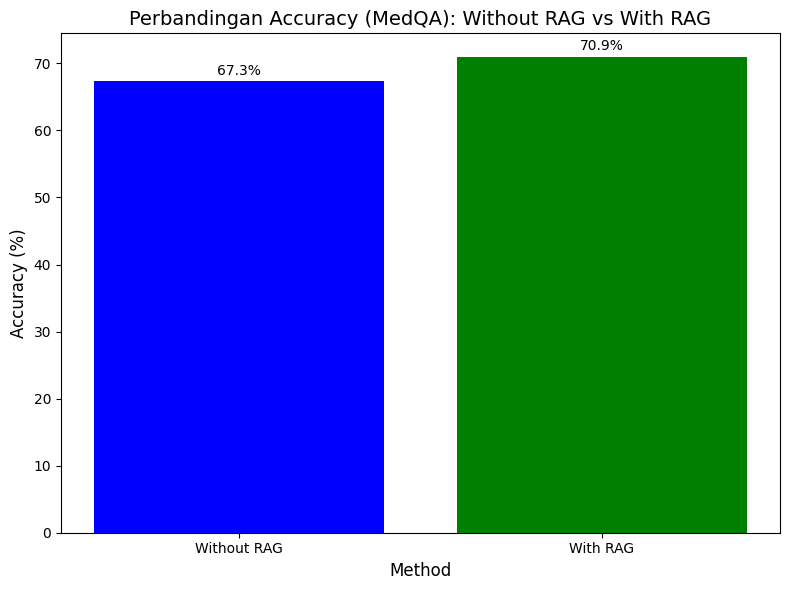

In [240]:
import matplotlib.pyplot as plt
labels = ['Without RAG', 'With RAG']

accuracies = [without_rag_acc, with_rag_acc]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green'])

plt.title('Perbandingan Accuracy (MedQA): Without RAG vs With RAG', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()